In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%pushd
%cd ".."
from mjs import tracks
import mjs.plot  
from lib.rp_extract import audiofile_read
import numpy as np
import matplotlib.pyplot as pyplot
import matplotlib.mlab
import scipy.signal
import scipy.fftpack
%popd
print dir(tracks)

/home/mars/musictools
/home/mars/musictools/scrapbook
popd -> ~/musictools/scrapbook
['__builtins__', '__doc__', '__file__', '__name__', '__package__', 'burning_sun', 'entropath', 'library', 'lucid_illusions', 'new_rhythm', 'path', 'taphon']


In [2]:
samplerate, samplewidth, wavedata = audiofile_read.audiofile_read("/home/mars/musictools/loop.wav")
nsamples = wavedata.shape[0]
nchannels = wavedata.shape[1]
print samplerate, "Hz,", samplewidth*8, "bit,", nchannels, "channel(s),", nsamples, "samples"

44100 Hz, 24 bit, 2 channel(s), 1338474 samples


In [3]:
samples = wavedata.copy()
# Reduce audio to a single channel
if len(samples.shape) > 1:
    samples = samples.mean(axis=1)

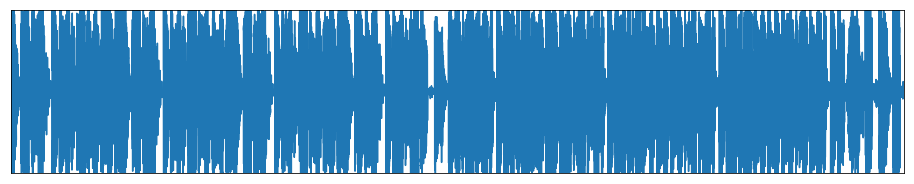

In [4]:
fig = pyplot.figure(num=None, figsize=(16, 3), dpi=72, facecolor='w', edgecolor='k')
axes = fig.add_subplot(111)
mjs.plot.waveform(axes, samples)
pyplot.show()


In [5]:
samples = wavedata.copy()

as_strided = np.lib.stride_tricks.as_strided

frame_size = 1024
overlap = 4
# Hanning window function coefficients.
hann = 0.5 - 0.5 * np.cos(2.0 * np.pi * (np.arange(frame_size)) / frame_size)

step_size = frame_size * (overlap-1) / overlap
padding = step_size - (len(samples) % step_size)
if padding:
    np.pad(samples, (0,padding), 'constant')
    
as_strided = np.lib.stride_tricks.as_strided
bin_count = len(samples)/step_size
shape = (bin_count, frame_size)
strides = (samples.strides[0] * step_size, samples.strides[0])
frames = as_strided(samples, shape=shape, strides=strides)

spectrogram = []
for frame in frames:
    # take FFT and discard symmetric part of the result
    spectrogram.append(np.fft.rfft(frame * hann)[:frame_size//2])

spectrogram = np.column_stack(spectrogram)

# take absolute value to get magnitude
spectrogram = np.absolute(spectrogram) * 2.0 / np.sum(hann)
# convert to decibels, clip noise floor
spectrogram = (20 * np.log10(spectrogram)).clip(-120)


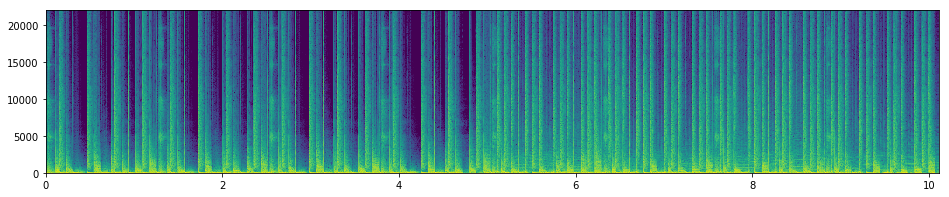

In [6]:
fig = pyplot.figure(num=None, figsize=(16, 3), dpi=72, facecolor='w', edgecolor='k')
axes = fig.add_subplot(111)

times = np.arange(0, spectrogram.shape[1], dtype=np.float) * frame_size / samplerate / overlap
freqs = np.arange(0, frame_size / 2, dtype=np.float) * samplerate / frame_size

axes.pcolormesh(times, freqs, spectrogram, vmin=-120, vmax=0)
axes.set_xlim(0, times[-1])
axes.set_ylim(0, freqs[-1])

pyplot.show()